# Function Generation for the Training of λ-Nets

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 5,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'function_generation_type': 'make_classification_trained', # 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
    }, 
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

## Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from more_itertools import random_product 
from tqdm import tqdm_notebook as tqdm
import pickle

import numpy as np

import pandas as pd
from joblib import Parallel, delayed

import random 
from random import sample 

import os
import sys

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

from sympy import Symbol, sympify

        
import seaborn as sns
        
import random 

import warnings

from time import perf_counter



from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utilities.DecisionTree_BASIC import SDT
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from IPython.display import Image

import numpy as np
import torch
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
os.environ['CUDA_VISIBLE_DEVICES'] = ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='data_creation'))
generate_directory_structure()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_function_data)

lNetSize5000_numDatasets10000_var9_class2_make_classification_trained_xMax1_xMin0_xDistuniform_cat0-1-2-3_depth5_beta1_decisionSpars1_vanilla_fullyGrown


# Function Generation

In [7]:
if function_generation_type == 'random_decision_tree':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))
elif function_generation_type == 'random_decision_tree_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))  
elif function_generation_type == 'make_classification':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    

function_identifier_list = generate_decision_tree_identifier(config)  
identifier_series_list = [pd.Series(result[0],  index=function_identifier_list) for result in result_list]

function_df = pd.DataFrame(data=np.array([result[0] for result in result_list]), columns=function_identifier_list)

X_data_list = [[identifier_series, pd.DataFrame(result[1], columns=['x' + str(i) for i in range(number_of_variables)])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_list = [[identifier_series, pd.DataFrame(result[2], columns=['result'])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_raw_list = [[identifier_series, pd.DataFrame(result[3], columns=['result_raw'])] for identifier_series, result in zip(identifier_series_list, result_list)]


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-3)]: Done 100 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-3)]: Done 260 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-3)]: Done 618 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-3)]: Done 1194 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-3)]: Done 1898 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-3)]: Done 2730 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-3)]: Done 3690 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-3)]: Done 4778 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-3)]: Done 5994 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done 7338 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 8810 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 9973 out of 10000 | elapsed:  1.4min remaining:    0.2s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:  1.4min finished


In [8]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,split15,split16,split17,split18,split19,split20,split21,split22,split23,split24,split25,split26,split27,split28,split29,split30,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,lp16,lp17,lp18,lp19,lp20,lp21,lp22,lp23,lp24,lp25,lp26,lp27,lp28,lp29,lp30,lp31
0,0.516,0.388,0.500,0.591,0.430,0.507,0.483,0.430,0.179,0.500,0.479,0.500,0.412,0.500,0.500,0.607,0.500,-1.000,0.419,0.932,0.448,0.445,0.687,0.501,0.447,0.528,0.490,0.499,0.468,0.633,0.542,8.000,6.000,0.000,4.000,7.000,7.000,7.000,4.000,6.000,3.000,4.000,3.000,4.000,3.000,2.000,7.000,1.000,-1.000,8.000,4.000,8.000,5.000,6.000,6.000,5.000,7.000,5.000,6.000,4.000,5.000,4.000,0.986,0.750,0.713,0.091,1.000,1.000,0.400,0.000,0.028,1.000,0.227,0.566,0.768,0.402,0.191,0.417,0.661,0.180,0.673,0.962,0.864,0.992,0.808,0.943,0.287,0.011,0.386,0.710,0.942,0.167,0.645,0.225
1,0.500,0.490,0.095,0.628,0.604,-1.000,0.209,0.336,0.527,0.383,0.500,-1.000,-1.000,0.685,0.249,0.476,0.593,0.191,0.731,0.500,0.458,0.687,0.392,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.248,0.499,3.000,4.000,4.000,6.000,5.000,-1.000,4.000,5.000,5.000,6.000,1.000,-1.000,-1.000,6.000,4.000,6.000,6.000,4.000,6.000,1.000,6.000,6.000,8.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,4.000,6.000,0.000,1.000,0.003,0.162,0.200,1.000,0.028,0.429,0.000,1.000,0.828,0.997,0.033,0.800,0.667,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.972,0.999
2,0.456,0.500,0.479,0.344,0.500,0.483,0.500,0.500,0.396,0.491,0.441,0.500,0.471,0.435,0.501,0.274,0.453,0.500,0.582,0.500,0.376,0.500,0.376,0.524,-1.000,-1.000,0.472,0.554,0.692,0.296,0.562,5.000,2.000,6.000,8.000,1.000,5.000,3.000,1.000,4.000,4.000,4.000,1.000,6.000,8.000,4.000,8.000,5.000,3.000,6.000,3.000,8.000,3.000,8.000,4.000,-1.000,-1.000,6.000,4.000,4.000,8.000,5.000,0.118,0.714,0.029,0.500,0.846,0.000,0.984,0.273,0.929,0.026,0.407,0.847,0.368,0.009,0.092,0.346,0.043,0.688,0.000,0.000,0.000,0.000,0.667,0.000,0.645,0.103,0.984,0.000,0.545,0.026,0.577,0.104
3,0.508,0.471,0.616,0.372,0.452,0.331,0.500,0.500,0.242,0.351,0.550,0.500,0.538,0.629,0.500,0.542,0.500,0.357,0.342,0.500,0.830,0.657,0.398,0.514,0.437,0.286,0.563,0.482,0.379,0.530,0.479,5.000,7.000,7.000,5.000,5.000,8.000,2.000,0.000,8.000,8.000,7.000,3.000,7.000,5.000,0.000,4.000,1.000,4.000,8.000,3.000,6.000,4.000,8.000,5.000,6.000,4.000,5.000,8.000,4.000,4.000,8.000,0.143,0.000,1.000,0.000,1.000,0.000,0.706,0.961,0.027,0.310,0.002,1.000,0.429,0.944,0.330,0.015,1.000,0.051,0.933,0.545,0.820,0.980,0.517,0.854,0.583,0.061,0.533,0.931,0.194,0.935,0.107,0.000
4,0.500,0.354,0.437,0.367,0.591,0.500,0.389,0.264,0.277,0.500,0.500,-1.000,0.321,0.583,0.539,-1.000,0.657,0.496,0.400,0.454,0.500,0.274,0.581,-1.000,-1.000,0.448,0.327,0.502,0.667,0.201,0.500,0.000,4.000,7.000,6.000,6.000,2.000,6.000,8.000,7.000,2.000,4.000,-1.000,7.000,8.000,4.000,-1.000,7.000,6.000,6.000,4.000,3.000,5.000,8.000,-1.000,-1.000,6.000,5.000,7.000,7.000,5.000,2.000,1.000,1.000,0.000,1.000,0.000,1.000,0.714,1.000,0.100,0.008,0.640,0.014,0.250,1.000,0.038,0.800,0.000,0.000,0.000,0.000,0.000,0.750,0.846,1.000,0.240,0.928,0.074,0.875,0.667,0.975,0.344,0.990


In [9]:
X_data_list[0][0].head(10)

feat0   0.516
feat1   0.388
feat2   0.500
feat3   0.591
feat4   0.430
feat5   0.507
feat6   0.483
feat7   0.430
feat8   0.179
feat9   0.500
dtype: float64

In [10]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,1.000,0.000,0.000,0.000,0.305,0.640,0.659,0.197,0.536
1,0.000,0.000,1.000,0.000,0.487,0.651,0.493,0.440,0.588
2,0.000,0.000,1.000,1.000,0.385,0.512,0.425,0.654,0.519
3,0.000,0.000,1.000,1.000,0.583,0.668,0.580,0.517,0.381
4,0.000,1.000,1.000,1.000,0.147,1.000,0.086,0.327,0.371
5,1.000,1.000,0.000,1.000,0.339,0.491,0.553,0.407,0.532
6,0.000,0.000,0.000,1.000,0.322,0.491,0.742,0.629,0.677
7,1.000,1.000,1.000,1.000,0.524,0.473,0.558,0.693,0.461
8,0.000,1.000,0.000,1.000,0.424,0.639,0.409,0.514,0.556
9,0.000,0.000,1.000,0.000,0.670,0.405,0.500,0.525,0.439


In [11]:
y_data_list[0][0].head(10)

feat0   0.516
feat1   0.388
feat2   0.500
feat3   0.591
feat4   0.430
feat5   0.507
feat6   0.483
feat7   0.430
feat8   0.179
feat9   0.500
dtype: float64

In [12]:
y_data_list[1][1].head(10)

,result
0,0
1,1
2,0
3,1
4,1
5,1
6,0
7,0
8,0
9,0


In [13]:
y_data_list[2][1].head(10)

,result
0,1
1,0
2,1
3,1
4,1
5,0
6,0
7,1
8,0
9,1


In [14]:
y_data_raw_list[2][1].head(10)

,result_raw
0,1
1,0
2,1
3,1
4,1
5,0
6,0
7,1
8,0
9,1


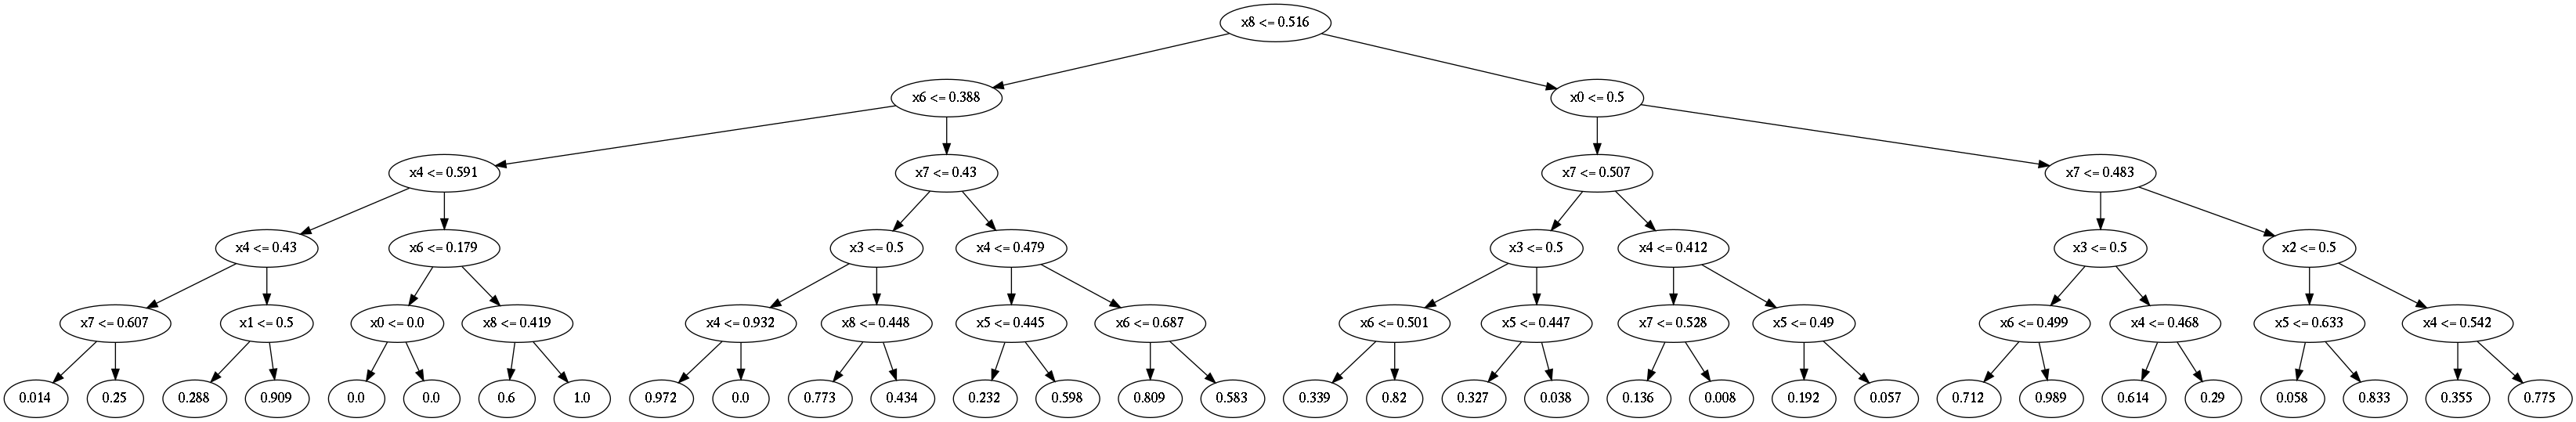

In [15]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [16]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df.to_csv(path_functions, index=False)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'wb') as f:
    pickle.dump(X_data_list, f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'wb') as f:
    pickle.dump(y_data_list, f)
